#   `lab08`—Image Manipulation

**Objectives**

- Represent images as three-dimensional arrays with length, width, and depth.
- Manipulate image data to obfuscate personally-identifying information using various techniques.

### Obscuring Images

In [1]:
#grade
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread,imsave

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-sfdhtbg0 because the default path (/tmp/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
%matplotlib inline

The moment digital images are created, they are subject to being manipulated, censored, and altered.  This is a source of enormous power for good and ill.  Today we will take a look at how image censorship can be implemented (either to protect individuals' anonymity or to conceal sensitive information).

Several strategies may be used to obscure information such as civilian faces or private data:

- [censor bars](https://infogalactic.com/info/Censor_bars) simply cover the information which needs to be concealed ([famously used by the federal government in released classified documents](http://www.theonion.com/article/cia-realizes-its-been-using-black-highlighters-all-1848))
- [pixelization](https://infogalactic.com/info/Pixelization) censors by dropping the local resolution of the information
- <a href="https://infogalactic.com/info/Fogging_(censorship)">fogging</a> applies a blur effect over an area which yields a smoother appearance than pixelization but has the same effect

<table>
<tr>
<td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Pixelization_mosaic.jpg/148px-Pixelization_mosaic.jpg" width="210px;"></td>
<td><img src="./img/fogging-example.png" width="150px;"></td>
</tr>
<tr><td>Censorship via pixelization</td><td>Censorship via fogging</td></tr>
</table>

In this lab, you will implement all three methods as an exercise in image manipulation.

###  Image Data Structure

We will use the `imageio` library function [`imread`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.misc.imread.html) to open an image file as a NumPy array.  Dimensions 0 and 1 of this array represent the 2D layout of the pixels, which are represented either as single values (if greyscale) or a three-element array (if color).

A black-and-white or greyscale image would be represented as follows:

![](tiny-python.png)

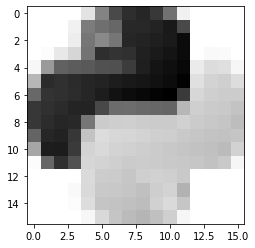

[[255 255 255 255 227 131  74  46  38  57 114 241 255 255 255 255]
 [255 255 255 241 124 111 103  41  40  35  25  74 255 255 255 255]
 [255 255 255 237 118 137 118  38  35  31  26  11 255 255 255 255]
 [255 252 232 214 115  46  51  48  32  26  20  11 255 249 250 255]
 [247 154  98  92  89  81  80  61  31  20  15   8 235 220 223 246]
 [183  43  48  43  38  35  29  25  22  17  12   2 224 212 207 221]
 [104  51  48  45  38  29  18  12   8   3   0  58 215 207 204 204]
 [ 55  49  43  37  35  72 108 109 106 103 101 183 207 203 201 195]
 [ 55  45  38  41 118 203 206 207 204 203 203 209 203 200 197 189]
 [100  38  34  55 195 220 215 214 212 207 206 201 198 195 194 197]
 [166  29  28  58 212 217 212 209 206 203 200 197 194 192 187 210]
 [252 103  48  81 214 212 207 203 204 203 201 200 198 194 201 246]
 [255 255 255 255 218 204 203 198 207 209 207 201 255 255 255 255]
 [255 255 255 249 217 201 200 197 192 206 212 178 255 255 255 255]
 [255 255 255 252 221 197 195 192 189 209 218 198 255 255 255 

In [3]:
python = imread( 'tiny-python.png' )
plt.imshow( python,cmap="gray" )

plt.show()
print( python )

We will flatten any color images to greyscale to make our subsequent work easier.

In [4]:
#grade
def rgb2gray( rgb ):
    '''
    Convert an array to greyscale.  Code by waspinator.
    '''
    r,g,b = rgb[ :,:,0 ],rgb[ :,:,1 ],rgb[ :,:,2 ]
    gray = 0.2989*r + 0.5870*g + 0.1140*b
    return gray

For representative images, we will use a sequence of pictures of famous whistleblowers:  [Julian Assange](https://en.wikipedia.org/wiki/WikiLeaks), [Edward Snowden](https://en.wikipedia.org/wiki/Edward_Snowden), and [Daniel Ellsberg](https://en.wikipedia.org/wiki/Pentagon_Papers).

Get the dimensions.  For `assange`, the total size can be found using `assange.shape`.  Note that the way they are displayed is _transposed_ relative to the way we think of coördinates:  be careful!

In [5]:
#grade
#assange = imread( 'https://i.imgur.com/TEqOgvK.png' )
assange = imread('assange.png')
assange = rgb2gray( assange )

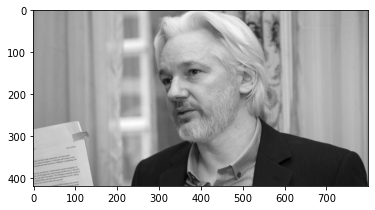

(#rows, #columns) = 420,800 = (range of y values, range of x values)


In [6]:
plt.imshow( assange,cmap="gray" )
plt.show()

print( "(#rows, #columns) = %i,%i = (range of y values, range of x values)" % (assange.shape[0],assange.shape[1] ) )

We will need to specify the coordinates of his face, which is centered at `(375,200)` or alternatively the rectangle from `(300,100)` to `(500,320)`.

> Again, due to `imshow`'s transposition of the displayed array, we are not treating $x$ and $y$ coordinates completely consistently below.  Just be careful and you shouldn't have any trouble.

##  Censor Bars

Applying censor bars to an image is quite straightforward, and just involves blacking out the pixel ranges involved (_i.e._, setting the values to zero).

The function you will compose, `censor`, needs to receive the image (`image`) and a range of pixels to censor (`patch`).  `patch` should be a tuple with four values, `( left,top,height,width )`.

<div class="alert alert-warning">
We are not making the implementation robust, so for instance selecting a range outside of the image range will lead to an <code>IndexError</code>.  (This isn't good for production code, but is fine for a quick-and-dirty implementation like this one.)
</div>

### <span style="color:#345995">Exercise 1: Black Out Data with a Censorship Bar</span>

-   Compose a function `censor( image,patch )` which accepts these parameters and returns an image `outimage` with the patch replaced by `0`s.  (Note that black for a greyscale image is different from black for a color image!  How?)

In [11]:
#grade
def censor( image,patch ):
    outimage = image.copy()
    black = 0 # black
    
    left,top,height,width = patch
    for w in range(300,500): # what range using left,width
        for h in range(100,320):  # what range using top,height
            outimage[ h,w ] = black #black
    return outimage

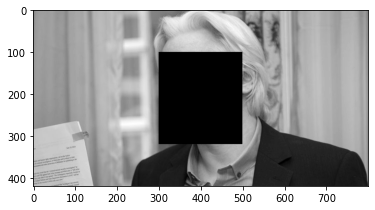

In [14]:
#grade
assange_censored = censor( assange,( 300,100,220,200 ) )
plt.imshow( assange_censored,cmap="gray" )
plt.show()

In [15]:
#grade
assange_output = assange_censored[100:110,300:310]

##  Pixelization

In [31]:
#grade
snowden = imread( 'snowden.png' )
snowden = rgb2gray( snowden )

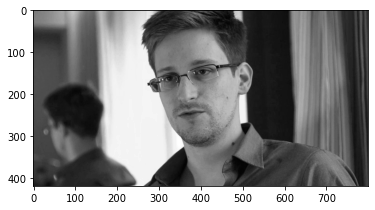

(#rows, #columns) = 420,800 = (range of y values, range of x values)


In [32]:
plt.imshow( snowden,cmap="gray" )
plt.show()

print( "(#rows, #columns) = %i,%i = (range of y values, range of x values)" % (snowden.shape[0],snowden.shape[1] ) )

We could proceed one of two ways to pixelate the image.  We could select a portion of the image, scale it down (_resample_ it) and then scale that sector back up to size; or we could simply select successive blocks as giant "pixels" and average the value of the pixels within that block.  Libraries such as [Pillow](https://python-pillow.org/) support the first, but we'll implement the second way since it requires more interesting math of you.

What you will do is select each block and average the values inside of it, then share that average value with all of the pixels in that block.  In the graphic below, as each 2×2 block is selected, it is replaced by the average value, resulting finally in the pixelated block at bottom.

![](./img/pixelization.png)

The function you will compose, `pixelate`, needs to receive the image (`image`), a range of pixels to pixelate (`patch`), and a resolution to pixelate to (`res`).  Your result should look like this:

![](./snowden_pixelated.png)

### <span style="color:#345995">Exercise 2: Pixelate Faces</span>

-   Compose a function `pixelate( image,patch,res )` which accepts these parameters and returns an image `outimage` with the patch transformed into `res`$\times$`res`-pixel blocks.  `res` should default to `10`.

In [37]:
#grade
def pixelate( image,patch,res=10 ):  # set the default!
    outimage = image.copy()
    left,top,height,width = patch
    xstride = range(top, top+height, res)  # use top here and think about jumping res steps for the entire height
    ystride = range(left, left+width, res) # use left here and think about jumping res steps for the entire width
    for i in xstride:
        for j in ystride:
            outimage[ i:i+res, j:j+res ] = outimage[ i:i+res, j:j+res ].mean()  # what should the range of each block be?
    return outimage

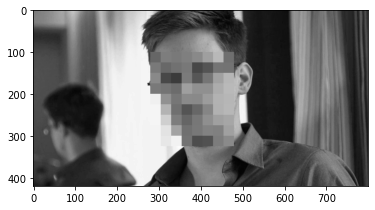

In [38]:
#grade
# Test your function on the image.
snowden_pixelated = pixelate( snowden,( 280,100,220,200 ),25 )
plt.imshow( snowden_pixelated, cmap="gray" )
plt.show()

In [39]:
#grade
snowden_output = snowden_pixelated[280:290,100:110]

In [40]:
assert np.isclose(np.array([32.8674, 34.0953, 34.1061, 33.4051, 33.4051, 33.1062, 31.8074, 29.0357, 26.036 , 26.3241]), np.array(snowden_output[0,:])).all()
print("Success!")

Success!


##  Fogging

In [41]:
#grade
ellsberg = imread( 'ellsberg.png' )
ellsberg = rgb2gray( ellsberg )

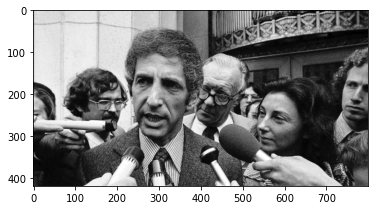

(#rows, #columns) = 420,800 = (range of y values, range of x values)


In [42]:
plt.imshow( ellsberg,cmap="gray" )
plt.show()

print( "(#rows, #columns) = %i,%i = (range of y values, range of x values)" % (ellsberg.shape[0],ellsberg.shape[1] ) )

To blur the image, you need to use a function to average together neighboring pixels in order to reduce detail.  One simple way to achieve this is the [box blur](), in which the average of neighboring pixels in a sliding block are used to determine the pixel's new value.

    255 255 245
    128 110  96   →   121 (at the center)
      0   0   0

Other popular filters which one often sees in image processing applications like Adobe Photoshop or GIMP include the [gaussian blur](https://infogalactic.com/info/Gaussian_blur) and the circular box blur.

The function you will compose, `fog`, needs to receive the image (`image`), a range of pixels to pixelate (`patch`), and a "radius" to blur (`radius`, really the limits of the sliding box).

### <span style="color:#345995">Exercise 3: Blur Image Data</span>

-   Compose a function `fog( image,patch,radius )` which accepts these parameters and returns an image `outimage` with a patch blurred.  `radius` should default to 5.

In [56]:
#grade
def fog( image,patch,radius=5 ):
    outimage = image.copy()
    
    left,top,height,width = patch
    
    for w in range(left,left+width):       # should go one pixel at a time and use left,width
        for h in range(top, top+height):   # should go one pixel at a time and use top,height
            outimage[ h,w ] = image[ h-radius:h+radius, w-radius:w+radius ].mean() # should be the mean of the surrounding box of perimeter 2*radius, based on image, not outimage---why?
    return outimage

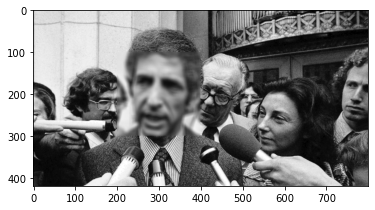

In [57]:
# Test your function on the image.
ellsberg_fogged = fog( ellsberg,( 200,100,200,200 ) )
plt.imshow( ellsberg_fogged,cmap="gray" )
plt.show()

That looks pretty good, but the edges of the patch are sharp and somewhat jarring.  Let's improve on that.

Finally, you will create a function which is itself smoothed out, so that the edges of the censored patch blend seamlessly with the surrounding image context.  We will make two changes in our approach to facilitate this:

1.  Change from a box patch to a circular patch.
2.  Vary the radius of the box blur from 1 at the edge to a maximum near the center.  We can use the same logic as the `fog` function to accomplish this.

The function you will compose, `smoothfog`, needs to receive the image (`image`) and the center of the circle and its radius (`center`, a three-member tuple).

### <span style="color:#345995">Exercise 4: Blur Image Data Smoothly</span>

-   Compose a function `smoothfog( image,center )` which accepts these parameters and returns an image `outimage` with a patch blurred smoothly.

In [78]:
#grade
from scipy.spatial.distance import euclidean as dist

def smoothfog( image,center ):
    outimage = image.copy()
    
    cirx,ciry,cirr = center
    
    for w in range(cirx-cirr,cirx+cirr):       # should use cirr and cirx to define x boundaries
        for h in range(ciry-cirr,ciry+cirr):   # should use cirr and ciry to define y boundaries
            radius = dist( np.array( ( w,h ) ),np.array( ( cirx,ciry ) ) )
            if radius > cirr :  # and filter out the pixels outside the circle
                continue  # don't alter pixels outside the circle
            rad = int(cirr-radius)  # set `rad`, the distance of the pixel from the edge of the circle, as an int
            outimage[ h,w ] = image[ h-rad:h+rad+1, w-rad:w+rad+1 ].mean() # set as with `fog` but using `rad` instead
    return outimage

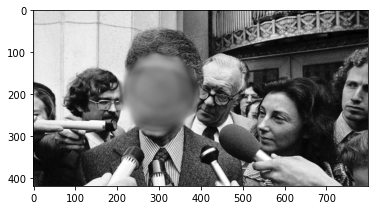

In [79]:
# Test your function on the image.
ellsberg_fogged = smoothfog( ellsberg,( 300,200,100 ) )
plt.imshow( ellsberg_fogged,cmap="gray" )
plt.show()

In [80]:
#grade
fog_output = smoothfog( ellsberg,( 300,200,100 ) )[300,200]

The thin white line at the radius of the circle occurs because the range `i-rad:i+rad` becomes empty at the limit.  To eliminate it, simply skip those lines thus:

    if rad == 0: continue  # after calculating `rad`, before setting `outimage`

If implemented correctly above, then this should work in color as well:

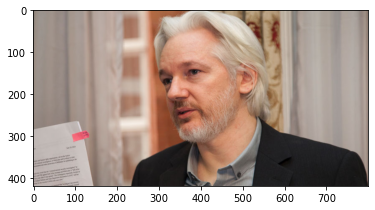

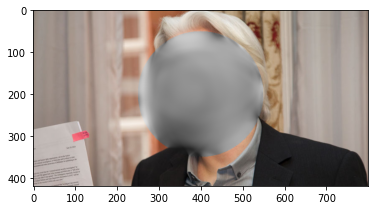

In [81]:
assange_rgb = imread( 'assange.png' )
plt.imshow( assange_rgb )
plt.show()

assange_smoothed = smoothfog( assange_rgb,( 400,200,150 ) )
plt.imshow( assange_smoothed )
plt.show()

### <span style="color:#345995">Exercise 5: Edits to smoothfog</span>

Interestingly, since everything is averaged the filtered portion becomes greyscale.  To fix this, we have to average over a single dimension at a time.  Copy `smoothfog` from above and change the `mean()` statement to `mean( axis=0 ).mean( axis=0 )` (_i.e._ chomp the first axis twice when averaging).

In [84]:
# Place your modified `smoothfog` here.
from scipy.spatial.distance import euclidean as dist

def smoothfog( image,center ):
    outimage = image.copy()
    
    cirx,ciry,cirr = center
    
    for w in range(cirx-cirr,cirx+cirr):       # should use cirr and cirx to define x boundaries
        for h in range(ciry-cirr,ciry+cirr):   # should use cirr and ciry to define y boundaries
            radius = dist( np.array( ( w,h ) ),np.array( ( cirx,ciry ) ) )
            if radius > cirr :  # and filter out the pixels outside the circle
                continue  # don't alter pixels outside the circle
            rad = int(cirr-radius)  # set `rad`, the distance of the pixel from the edge of the circle, as an int
            outimage[ h,w ] = image[ h-rad:h+rad+1, w-rad:w+rad+1 ].mean( axis=0 ).mean( axis=0 ) # set as with `fog` but using `rad` instead
    return outimage

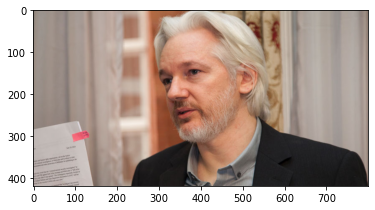

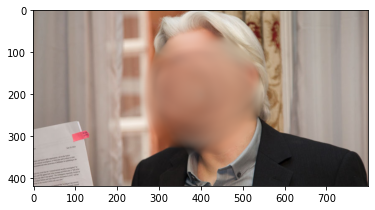

In [86]:
assange_rgb = imread( 'assange.png' )
plt.imshow( assange_rgb )
plt.show()

assange_smoothed = smoothfog( assange_rgb,( 400,200,150 ) )
plt.imshow( assange_smoothed )
plt.show()

This concludes our lab on the mechanics of images and image manipulation using Python.  Most programming languages, including MATLAB, adopt a similar representation when working with images.